In [4]:
cd ..

/Users/peabody/Documents/galvanize/capstones/strava


In [5]:
import numpy as np
import pandas as pd
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from stravalib.client import Client

from src.get_strava_data import StravaAthlete
import src.data_cleanup as cln

from src.features import unpack_dict_col, curvy1, curvy2

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import decomposition

pd.set_option('display.max_columns', 500)

In [6]:
ath_df = pd.read_csv('data/athletes.csv') 
ride_ids = pd.read_csv('data/Feldy_Bikes/ride_ids.csv')
segments_df = pd.read_csv('data/Feldy_Bikes/segments_df.csv')
efforts_df = pd.read_csv('data/Feldy_Bikes/efforts_df.csv')
seg_details_df = pd.read_csv('data/seg_details_df.csv')

In [7]:
seg_details_df = unpack_dict_col(seg_details_df, 'map', 'polyline')

In [8]:
curvy1(seg_details_df.polyline[0])

1537.6544267617935

In [9]:
# print(seg_details_df.shape)
# seg_details_df = seg_details_df.dropna()
# print(seg_details_df.shape)

In [10]:
seg_details_df['curvy1'] = seg_details_df.polyline.apply(lambda row: curvy1(row))
seg_details_df['curvy2'] = seg_details_df.polyline.apply(lambda row: curvy2(row))

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of em

In [11]:
seg_details_df.head(3)

,segment_id,name,distance,average_grade,maximum_grade,elevation_high,elevation_low,total_elevation_gain,start_latitude,end_latitude,start_longitude,end_longitude,climb_category,city,state,country,effort_count,athlete_count,athlete_segment_stats,map,polyline,curvy1,curvy2
0,12338997,For All The Lil Groms,94.30,-2.3,1.5,1677.4,1674.4,0.0000,39.758621,39.758319,-105.219889,-105.219699,0,Golden,Colorado,United States,22291,5310,"{'effort_count': 104, 'pr_elapsed_time': '0:00...","{'id': 's12338997', 'polyline': 'kjtqFhweaSBC?...",kjtqFhweaSBC?Qn@sA\RSn@,1537.654427,0.133020
1,991763,Tunnel to Tunnel,445.34,4.5,29.1,1809.3,1788.7,23.5522,39.735290,39.731473,-105.214684,-105.215807,0,Golden,CO,United States,14963,2849,"{'effort_count': 221, 'pr_elapsed_time': '0:00...","{'id': 's991763', 'polyline': 'qxoqFxvdaSrATLr...",qxoqFxvdaSrATLrATh@b@Jd@Vh@b@h@Rv@P~@\l@^v@Vh@...,217.146767,0.032840
2,1284311,Golden Cruise: Parking Lot to First Parking Ga...,485.70,-0.5,6.1,1726.4,1722.2,0.0000,39.759567,39.756275,-105.219683,-105.220585,0,Golden,CO,United States,1780,642,"{'effort_count': 129, 'pr_elapsed_time': '0:01...","{'id': 's1284311', 'polyline': 'gptqF`veaSVl@V...",gptqF`veaSVl@Vb@VANS@Qx@c@J@R\ZDh@c@PGJ?@FZD\?...,1030.710379,0.048573


In [12]:
# kp = StravaAthlete(token = 'de05acb15a17c6dfa6008f7d6e122b328e57b228')

# kp.add_athlete()
# ath_df = kp.ath_df 

# kp.get_rides()
# ride_ids = kp.ride_ids

# kp.get_segments()
# segments_df = kp.segments_df

# kp.get_efforts()
# efforts_df = kp.efforts_df

# seg_details_df = pd.read_csv('data/seg_details_df.csv')

In [13]:
segments_df = segments_df[~segments_df.bike.isin(['CA Hardtail','Rented/Borrowed/Stolen '])]
segments_df['bike_type'] = segments_df['bike'].apply(lambda x: 'Road' if x in ['Carbon Road',
                                                                               'Road + Burley',
                                                                               'Road',
                                                                               'Fixed'] 
                                                                               else 'Mountain')
segments_by_bike_type = segments_df.groupby(['bike_type']).count().iloc[:,1].reset_index()
segments_by_bike_type.rename(columns={"ride_id": "number_of_attempts"}, inplace = True)

In [14]:
temp = segments_df[['segment_id','bike_type']]
temp['percent_road'] = np.where(segments_df['bike_type']=='Road',1,0)
bike_segment = temp.groupby('segment_id').mean().reset_index()
bike_segment['road_threshold'] = np.where(bike_segment.percent_road > .7, 1, np.where(bike_segment.percent_road < .3, 0, np.nan))

bike_segment.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,segment_id,percent_road,road_threshold
0,746,1.0,1.0
1,748,0.0,0.0
2,763,1.0,1.0
3,770,0.0,0.0
4,771,0.0,0.0


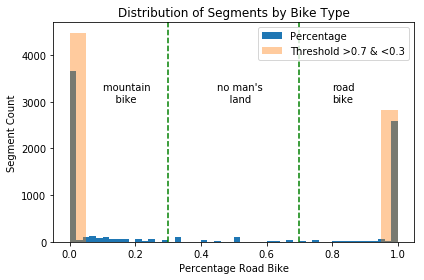

In [40]:
fig, ax = plt.subplots()

ax.hist(bike_segment.percent_road, bins = 50, label = 'Percentage')
ax.hist(bike_segment.road_threshold.dropna(), bins = 20, alpha = .4, label = 'Threshold >0.7 & <0.3')
ax.set_title('Distribution of Segments by Bike Type')
ax.set_ylabel('Segment Count')
ax.set_xlabel('Percentage Road Bike')
ax.axvline(.3, c = 'g', linestyle = '--')
ax.axvline(.7, c = 'g', linestyle = '--')
ax.annotate('mountain \n    bike', xy = (.1, 3000))
ax.annotate('no man\'s \n    land', xy = (.45, 3000))
ax.annotate('road\nbike', xy = (.8, 3000))
ax.legend()

plt.tight_layout();

In [16]:
segments_df.head()

,ride_name,ride_id,bike,ride_distance,ride_moving_time,ride_elapsed_time,ride_elevation_gain,ride_start_time,segment_id,bike_type
0,"07/30/2012 Golden, CO",40082170,Road,18.708238,0 days 01:22:35.000000000,0 days 10:40:32.000000000,970.472472,2012-07-30 07:20:46,12338997,Road
1,"07/30/2012 Golden, CO",40082170,Road,18.708238,0 days 01:22:35.000000000,0 days 10:40:32.000000000,970.472472,2012-07-30 07:20:46,991763,Road
2,"07/30/2012 Golden, CO",40082170,Road,18.708238,0 days 01:22:35.000000000,0 days 10:40:32.000000000,970.472472,2012-07-30 07:20:46,1284311,Road
3,"07/30/2012 Golden, CO",40082170,Road,18.708238,0 days 01:22:35.000000000,0 days 10:40:32.000000000,970.472472,2012-07-30 07:20:46,17747809,Road
4,"07/30/2012 Golden, CO",40082170,Road,18.708238,0 days 01:22:35.000000000,0 days 10:40:32.000000000,970.472472,2012-07-30 07:20:46,7431006,Road


In [17]:
eff_seg_deats = pd.merge(efforts_df, seg_details_df, on = ['segment_id','name'], how = 'inner')
eff_seg_deats = pd.merge(eff_seg_deats, segments_df, on = 'segment_id', how = 'inner')
eff_seg_deats = pd.merge(eff_seg_deats, bike_segment, on = 'segment_id', how = 'inner')

In [18]:
bike_selector_df = eff_seg_deats.dropna()
bike_selector_df.loc[:,'moving_time'] = bike_selector_df.loc[:,'moving_time'].apply(cln.get_sec)
bike_selector_df.loc[:,'elapsed_time'] = bike_selector_df.loc[:,'elapsed_time'].apply(cln.get_sec)

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


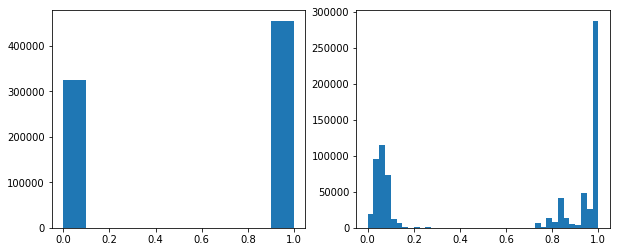

In [19]:
fig, ax = plt.subplots(1,2, figsize = (10,4))

ax[0].hist(bike_selector_df.road_threshold)
ax[1].hist(bike_selector_df.percent_road, bins = 40);

In [20]:
model_df = bike_selector_df[['distance','average_grade','elevation_low','elapsed_time',
                             'average_heartrate', 'curvy1', 'curvy2', 'road_threshold']]
model_df.loc[:,'avg_speed'] = model_df.distance/model_df.elapsed_time
model_df.drop_duplicates(inplace = True)

X = model_df[['distance','average_grade','elevation_low','elapsed_time','average_heartrate', 'curvy1', 'curvy2']]
y = np.array(model_df[['road_threshold']]).T[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X.shape)
model_df.head(3)

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


(18251, 7)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,distance,average_grade,elevation_low,elapsed_time,average_heartrate,curvy1,curvy2,road_threshold,avg_speed
565,1948.42,-6.7,2034.2,452,135.9,580.772482,0.025596,0.0,4.310664
3051,1948.42,-6.7,2034.2,382,147.0,580.772482,0.025596,0.0,5.100576
3164,1948.42,-6.7,2034.2,427,124.8,580.772482,0.025596,0.0,4.563044


In [59]:
bpdf = model_df[['avg_speed','curvy1','curvy2','road_threshold','average_heartrate']]
bpdf.road_threshold = np.where(bpdf.road_threshold == 0, 'mountain', 'road')

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:203: UserWarning: When passing multiple axes, layout keyword is ignored
  "ignored", UserWarning)
/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:2254: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  return_type=return_type, **kwds)


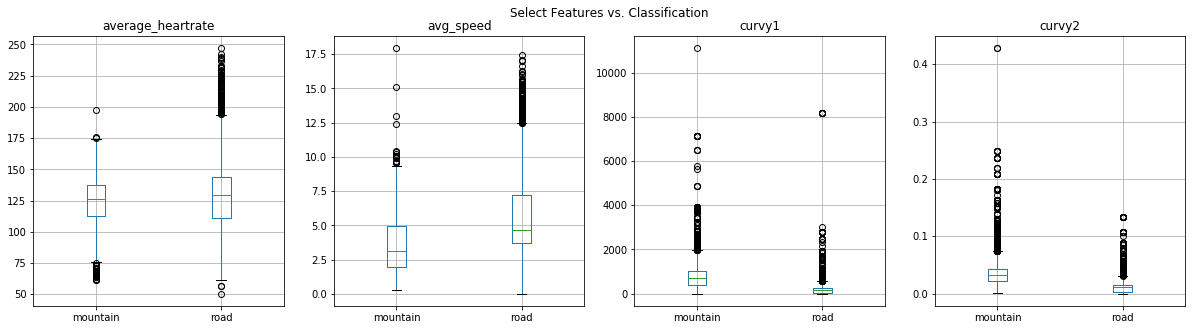

In [60]:
fig, ax_new = plt.subplots(1,bpdf.shape[1]-1, sharey=False,figsize=(20,5))
bp = bpdf.boxplot(by="road_threshold",
                      ax=ax_new,
                      layout=(1,bpdf.shape[1]-1))
[ax_tmp.set_xlabel('') for ax_tmp in ax_new.reshape(-1)]
ax.set_xticklabels(['mountain','road'])
#[ax_tmp.set_ylim(-2, 2) for ax_tmp in ax_new[1]]
fig.suptitle('Select Features vs. Classification')
plt.show()

In [71]:
from scipy.stats import ttest_ind

In [99]:
def ttest_bike(df, col):
    return ttest_ind(df.drop('road_threshold', axis =1)[df['road_threshold'] == 1][col], 
                     df.drop('road_threshold', axis =1)[df['road_threshold'] == 0][col])

In [100]:
for col in model_df:
    print('{0}: \t \t tstat={1:.2f}, \t pvalue={2:.2E}'.format(col,ttest_bike(model_df, col)[0],ttest_bike(model_df, col)[1]))

distance: 	 	 tstat=12.29, 	 pvalue=1.47E-34
average_grade: 	 	 tstat=38.32, 	 pvalue=4.70E-309
elevation_low: 	 	 tstat=-29.34, 	 pvalue=6.00E-185
elapsed_time: 	 	 tstat=-16.79, 	 pvalue=8.44E-63
average_heartrate: 	 	 tstat=9.20, 	 pvalue=3.83E-20
curvy1: 	 	 tstat=-86.77, 	 pvalue=0.00E+00
curvy2: 	 	 tstat=-83.15, 	 pvalue=0.00E+00


KeyError: 'road_threshold'

/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


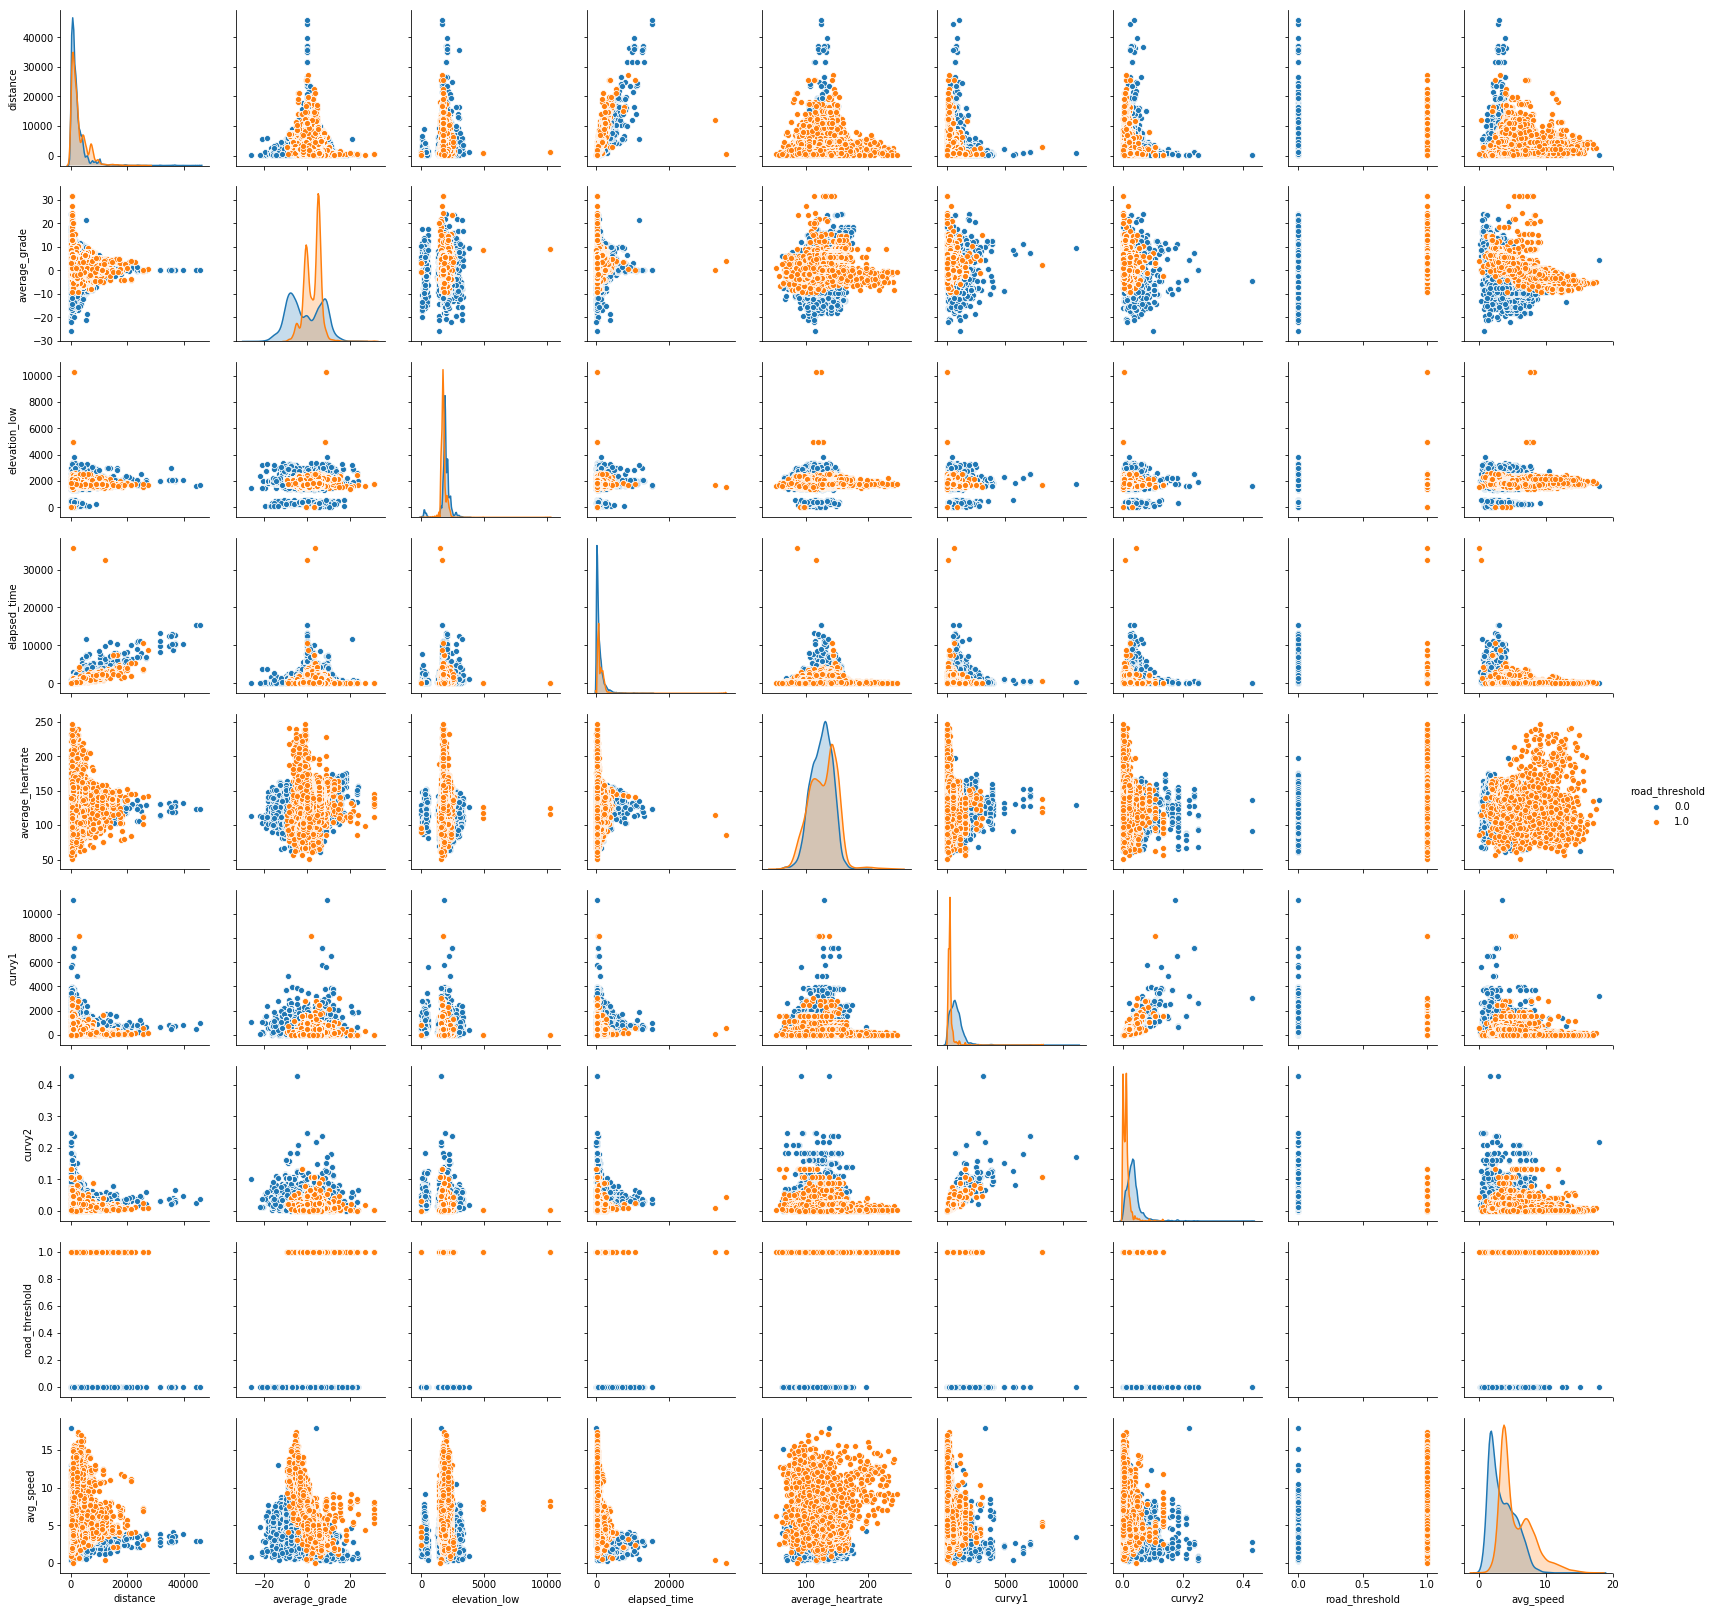

In [68]:
sns.pairplot(model_df, hue='road_threshold');

stuff to remove/test:
* low elevation is all mountain bike. Maybe just look in CO? OTOH, mountian is higher than road on average.
* heartrate has a big overlap, not a clear signal
* high correlation between curvy1 and curvy2; need to pick one.
* avg speed decorrelated distance and time

In [101]:
X = model_df[['avg_speed','average_grade','elevation_low', 'curvy1']]
y = np.array(model_df[['road_threshold']]).T[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X.shape)

(18251, 4)


In [64]:
thresholds = np.linspace(0,.99,100)

## Logistic Model

In [86]:
logistic_acc_list = []
logistic_recall_list = []
logistic_precision_list = []
logistic_results_list = []
model = LogisticRegression()
model.fit(X_train, y_train)
y_hat_probs = model.predict_proba(X_test)[:,1]
for th in thresholds:
    yhat = np.where(y_hat_probs > th, 1, 0)
    logistic_results_list.append(yhat)
    logistic_acc_list.append(accuracy_score(y_true = y_test, y_pred = yhat))
    logistic_recall_list.append(recall_score(y_true = y_test, y_pred = yhat))
    logistic_precision_list.append(precision_score(y_true = y_test, y_pred = yhat))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


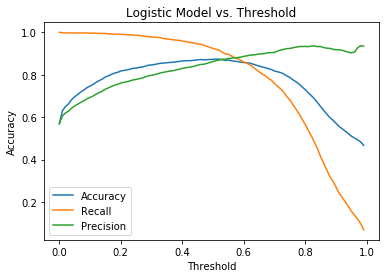

In [87]:
fig, ax = plt.subplots()

ax.plot(thresholds,logistic_acc_list, label = 'Accuracy')
ax.plot(thresholds,logistic_recall_list, label = 'Recall')
ax.plot(thresholds,logistic_precision_list, label = 'Precision')
ax.legend()
ax.set_xlabel('Threshold')
ax.set_ylabel('Accuracy')
ax.set_title('Logistic Model vs. Threshold');

In [88]:
log_threshold_max = np.argsort(logistic_acc_list)[::-1][0]
thresholds[log_threshold_max]

0.52

In [70]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes, ax,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    #fig, ax = plt.subplots() 
    fig = plt.subplots()[0] 
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    return ax

In [90]:
log_threshold_max = np.argsort(logistic_acc_list)[::-1][0]
thresholds[log_threshold_max]

0.52

''

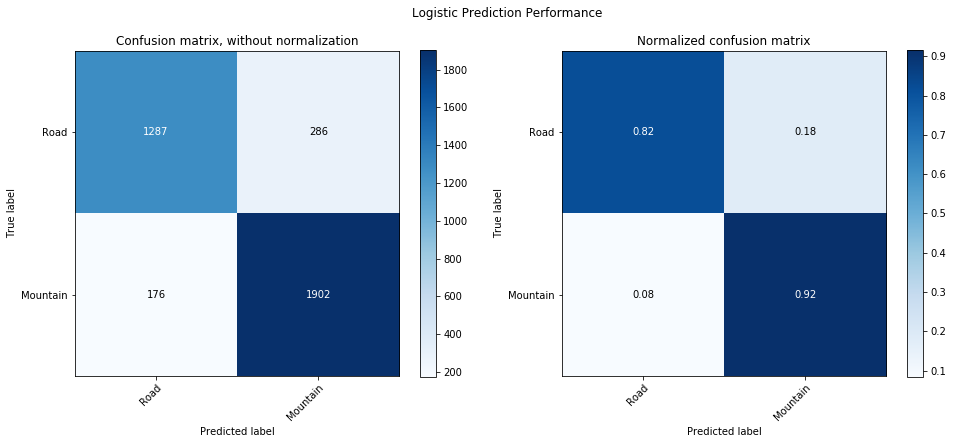

In [91]:
class_names = ['Road','Mountain']
fig, ax = plt.subplots(1,2, figsize = (16,6))

fig.suptitle('Logistic Prediction Performance')

plot_confusion_matrix(y_test, logistic_results_list[log_threshold_max], class_names, ax[0],
                              normalize=False,
                              title=None,
                              cmap=plt.cm.Blues)
plot_confusion_matrix(y_test, logistic_results_list[log_threshold_max], class_names, ax[1],
                              normalize=True,
                              title=None,
                              cmap=plt.cm.Blues)
plt.close(2) 
plt.close(3)
;

# Random Forest

In [65]:
X = model_df[['avg_speed','average_grade','elevation_low', 'curvy2']]
y = np.array(model_df[['road_threshold']]).T[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X.shape)

(18251, 4)


In [108]:
rf_acc_list = []
rf_recall_list = []
rf_precision_list = []
rf_results_list = []
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)
y_hat_probs = model.predict_proba(X_test)[:,1]
for th in thresholds:
    yhat = np.where(y_hat_probs > th, 1, 0)
    rf_results_list.append(yhat)
    rf_acc_list.append(accuracy_score(y_true = y_test, y_pred = yhat))
    rf_recall_list.append(recall_score(y_true = y_test, y_pred = yhat))
    rf_precision_list.append(precision_score(y_true = y_test, y_pred = yhat))

In [109]:
rf_threshold_max = np.argsort(rf_acc_list)[::-1][0]
thresholds[rf_threshold_max]

0.66

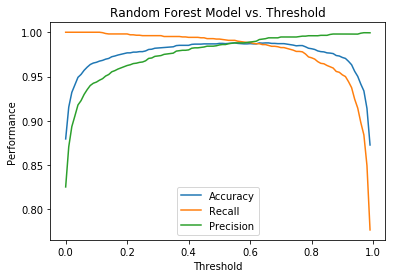

In [110]:
fig, ax = plt.subplots()

ax.plot(thresholds,rf_acc_list, label = 'Accuracy')
ax.plot(thresholds,rf_recall_list, label = 'Recall')
ax.plot(thresholds,rf_precision_list, label = 'Precision')
ax.legend()
ax.set_xlabel('Threshold')
ax.set_ylabel('Performance')
ax.set_title('Random Forest Model vs. Threshold');

''

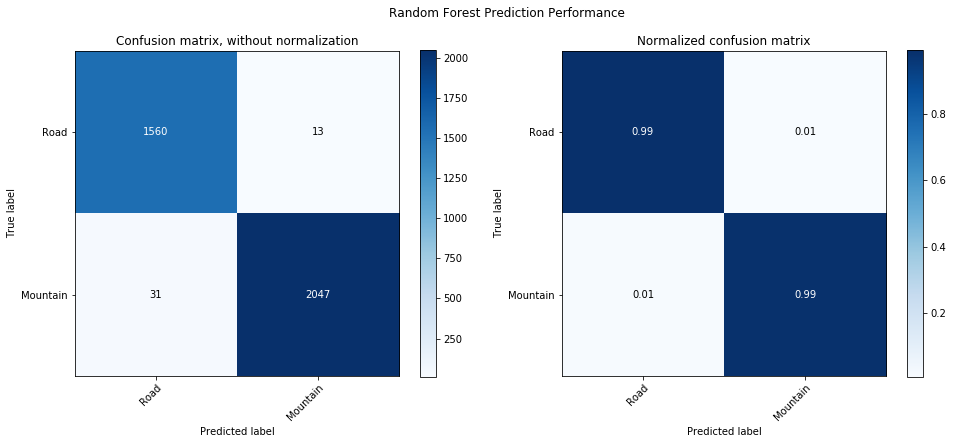

In [111]:
class_names = ['Road','Mountain']
fig, ax = plt.subplots(1,2, figsize = (16,6))

fig.suptitle('Random Forest Prediction Performance')

plot_confusion_matrix(y_test, rf_results_list[rf_threshold_max], class_names, ax[0],
                              normalize=False,
                              title=None,
                              cmap=plt.cm.Blues)
plot_confusion_matrix(y_test, rf_results_list[rf_threshold_max], class_names, ax[1],
                              normalize=True,
                              title=None,
                              cmap=plt.cm.Blues)
plt.close(2) 
plt.close(3)
;

In [94]:
X.shape

(18251, 4)

[3 0 1 2]
['curvy2', 'avg_speed', 'average_grade', 'elevation_low']
Feature ranking:
1. feature = curvy2 (36.7%)
2. feature = avg_speed (22.4%)
3. feature = average_grade (22.2%)
4. feature = elevation_low (18.7%)


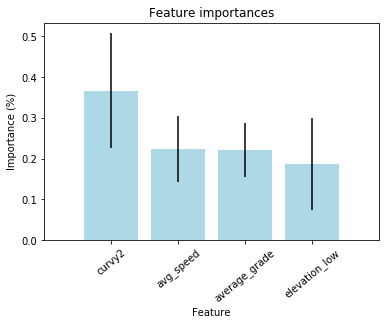

In [73]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = list(X.columns[indices])
print(indices)
print(features)

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("{}. feature = {} ({:.1%})".format(f + 1, features[f], importances[indices[f]]))


# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="lightblue", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), features, rotation = 40)
plt.xlim([-1, X.shape[1]])
plt.ylabel('Importance (%)')
plt.xlabel('Feature')
plt.show()

## Decision Tree

In [195]:
import pydotplus
from sklearn import tree
import collections
from IPython.display import Image 

In [185]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)

In [186]:
X.columns

Index(['avg_speed', 'average_grade', 'elevation_low', 'curvy2'], dtype='object')

In [199]:


# # Visualize data
# dot_data = tree.export_graphviz(clf,
#                                 feature_names=X.columns,
#                                 out_file=None,
#                                 filled=True,
#                                 rounded=True)
# graph = pydotplus.graph_from_dot_data(dot_data)

# colors = ('turquoise', 'orange')
# edges = collections.defaultdict(list)

# for edge in graph.get_edge_list():
#     edges[edge.get_source()].append(int(edge.get_destination()))

# for edge in edges:
#     edges[edge].sort()    
#     for i in range(2):
#         dest = graph.get_node(str(edges[edge][i]))[0]
#         dest.set_fillcolor(colors[i])

# graph.create_png();

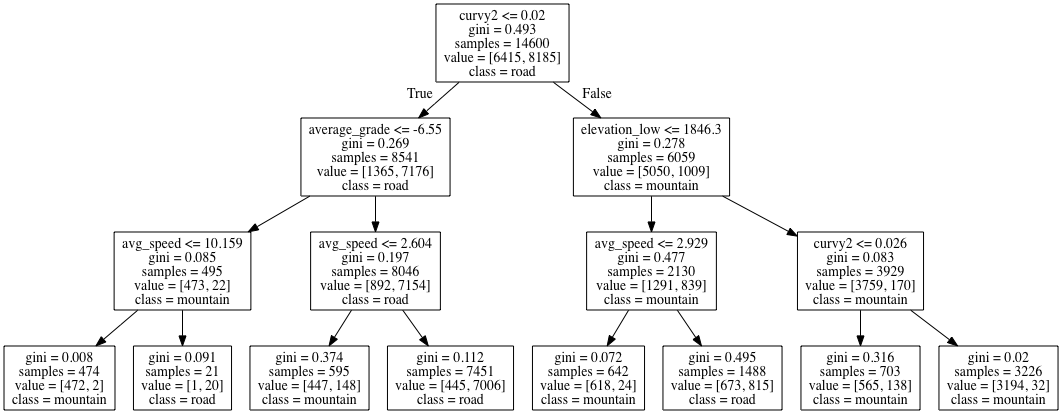

In [206]:
# Create decision tree classifer object
clf = tree.DecisionTreeClassifier(max_depth=3,random_state=0)

# Train model
model = clf.fit(X_train, y_train)

# Create DOT data
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=X_train.columns,  
                                class_names=['mountain','road'])

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())



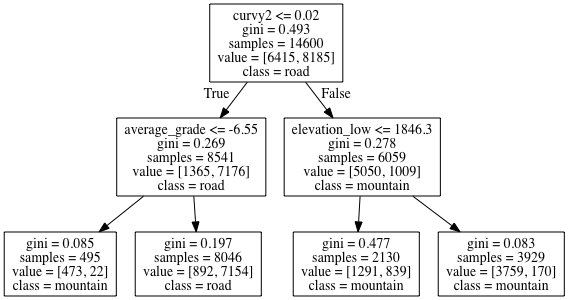

In [205]:
# Create decision tree classifer object
clf = tree.DecisionTreeClassifier(max_depth=2,random_state=0)

# Train model
model = clf.fit(X_train, y_train)

# Create DOT data
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=X_train.columns,  
                                class_names=['mountain','road'])

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

# KNN

In [104]:
knn_acc_list = []
knn_recall_list = []
knn_precision_list = []
knn_results_list = []
model = KNeighborsClassifier(n_neighbors=1)
model.fit(X_train, y_train)
y_hat_probs = model.predict_proba(X_test)[:,1]
for th in thresholds:
    yhat = np.where(y_hat_probs > th, 1, 0)
    knn_results_list.append(yhat)
    knn_acc_list.append(accuracy_score(y_true = y_test, y_pred = yhat))
    knn_recall_list.append(recall_score(y_true = y_test, y_pred = yhat))
    knn_precision_list.append(precision_score(y_true = y_test, y_pred = yhat))

In [105]:
knn_threshold_max = np.argsort(knn_acc_list)[::-1][0]
thresholds[knn_threshold_max]

0.99

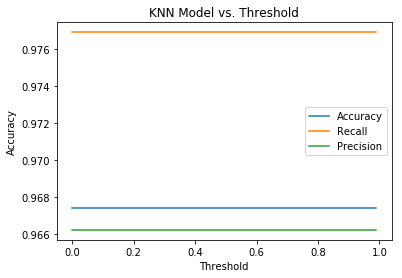

In [106]:
fig, ax = plt.subplots()

ax.plot(thresholds,knn_acc_list, label = 'Accuracy')
ax.plot(thresholds,knn_recall_list, label = 'Recall')
ax.plot(thresholds,knn_precision_list, label = 'Precision')
ax.legend()
ax.set_xlabel('Threshold')
ax.set_ylabel('Accuracy')
ax.set_title('KNN Model vs. Threshold');

Something is very strange here. Model gets more accurate with fewer neighbors. Best is 0???

''

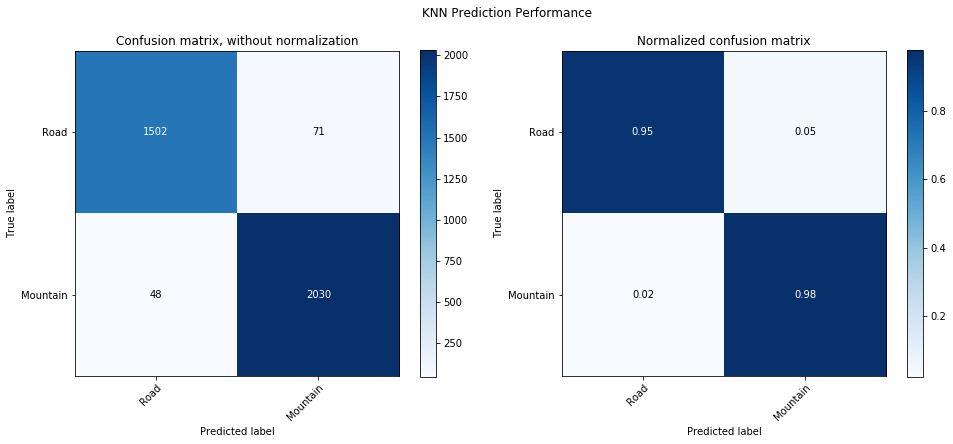

In [107]:
class_names = ['Road','Mountain']
fig, ax = plt.subplots(1,2, figsize = (16,6))

fig.suptitle('KNN Prediction Performance')

plot_confusion_matrix(y_test, knn_results_list[knn_threshold_max], class_names, ax[0],
                              normalize=False,
                              title=None,
                              cmap=plt.cm.Blues)
plot_confusion_matrix(y_test, knn_results_list[knn_threshold_max], class_names, ax[1],
                              normalize=True,
                              title=None,
                              cmap=plt.cm.Blues)
plt.close(2) 
plt.close(3)
;

## Naive Bayes

In [101]:
from sklearn.naive_bayes import GaussianNB
nb_acc_list = []
nb_recall_list = []
nb_precision_list = []
nb_results_list = []
model = GaussianNB()
model.fit(X_train, y_train)
y_hat_probs = model.predict_proba(X_test)[:,1]
for th in thresholds:
    yhat = np.where(y_hat_probs > th, 1, 0)
    nb_results_list.append(yhat)
    nb_acc_list.append(accuracy_score(y_true = y_test, y_pred = yhat))
    nb_recall_list.append(recall_score(y_true = y_test, y_pred = yhat))
    nb_precision_list.append(precision_score(y_true = y_test, y_pred = yhat))

In [103]:
nb_threshold_max = np.argsort(nb_acc_list)[::-1][0]
thresholds[nb_threshold_max]

0.75

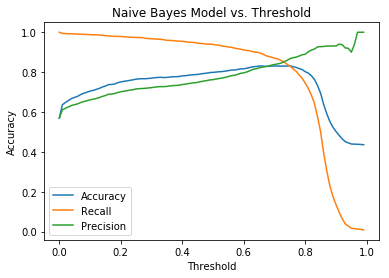

In [109]:
fig, ax = plt.subplots()

ax.plot(thresholds,nb_acc_list, label = 'Accuracy')
ax.plot(thresholds,nb_recall_list, label = 'Recall')
ax.plot(thresholds,nb_precision_list, label = 'Precision')
ax.legend()
ax.set_xlabel('Threshold')
ax.set_ylabel('Accuracy')
ax.set_title('Naive Bayes Model vs. Threshold');

## PCA

In [39]:
pca = decomposition.PCA(n_components=2)
pca.fit(X)
pcaX = pca.transform(X)

/anaconda3/lib/python3.7/site-packages/matplotlib/legend.py:798: UserWarning: Legend does not support 0.0 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/anaconda3/lib/python3.7/site-packages/matplotlib/legend.py:798: UserWarning: Legend does not support 0.0 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)


''

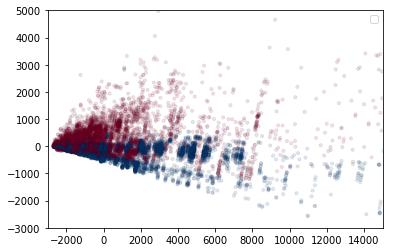

In [40]:
fig, ax = plt.subplots()

ax.scatter(pcaX[:,0],pcaX[:,1], c = y, alpha = .1, s = 10, cmap='RdBu', label = y)
ax.legend(y, ('mountain', 'road'))
ax.set_xlim(-3000,15000)
ax.set_ylim(-3000,5000)
;

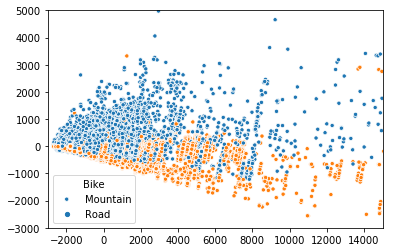

In [42]:
g = sns.scatterplot(pcaX[:,0],pcaX[:,1], hue = y, size = 1)
g.set_xlim(-3000,15000)
g.set_ylim(-3000,5000)
plt.legend(title='Bike', loc='lower left', labels=['Mountain', 'Road'])
plt.show(g)

## Kmeans

In [111]:
from sklearn.cluster import KMeans

In [116]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(X)

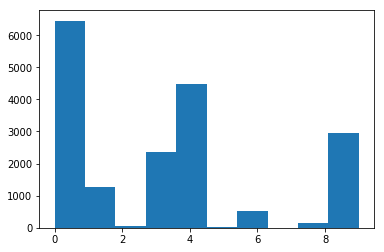

In [124]:
plt.hist(kmeans.labels_);

In [133]:
X2 = X
X2['cluster'] = kmeans.labels_
X2

,distance,average_grade,elevation_low,elapsed_time,average_heartrate,curvy2,cluster
565,1948.42,-6.7,2034.2,452,135.9,0.025596,4
3051,1948.42,-6.7,2034.2,382,147.0,0.025596,4
3164,1948.42,-6.7,2034.2,427,124.8,0.025596,4
3277,1948.42,-6.7,2034.2,413,136.8,0.025596,4
3503,1948.42,-6.7,2034.2,340,148.5,0.025596,4
4294,1948.42,-6.7,2034.2,570,131.0,0.025596,4
6554,1948.42,-6.7,2034.2,599,113.3,0.025596,4
8249,1948.42,-6.7,2034.2,355,154.5,0.025596,4
8701,1948.42,-6.7,2034.2,443,136.9,0.025596,4
9266,1948.42,-6.7,2034.2,586,140.2,0.025596,4


In [130]:
cluster_df = pd.merge(X2[['cluster']], seg_details_df, left_index = True, right_index = True)

In [132]:
cluster_df.head(100)

,cluster,segment_id,name,distance,average_grade,maximum_grade,elevation_high,elevation_low,total_elevation_gain,start_latitude,end_latitude,start_longitude,end_longitude,climb_category,city,state,country,effort_count,athlete_count,athlete_segment_stats,map,polyline,curvy2
565,4,3713409,82nd EB to Indiana,1375.930,0.0,6.1,1682.6,1675.4,7.20000,39.844423,39.843456,-105.182191,-105.166440,0,Arvada,CO,United States,16281,2997,"{'effort_count': 48, 'pr_elapsed_time': '0:02:...","{'id': 's3713409', 'polyline': 'sberFvk~`SzB{]...",sberFvk~`SzB{]L{FAuEEiCa@cII_CT}L?uAG}@_@{CBmA...,0.001664
3051,4,14783432,Antelope Bench to Nelson Loop Intersection - C...,2145.900,4.6,9.4,1944.9,1844.5,0.00000,40.220651,40.226908,-105.306565,-105.322367,1,Lyons,Colorado,United States,43242,8663,"{'effort_count': 3, 'pr_elapsed_time': '0:13:3...","{'id': 's14783432', 'polyline': 'arntF`uvaS]Ei...",arntF`uvaS]Ei@UWWKGg@CYFc@PGXOXI`@Sf@Oj@Dr@Qh@...,0.021813
3164,4,5543159,Parfet Up,811.900,3.0,6.3,1604.2,1579.6,24.60000,39.801417,39.794984,-105.119099,-105.121418,0,Arvada,CO,United States,1228,212,"{'effort_count': 1, 'pr_elapsed_time': '0:02:1...","{'id': 's5543159', 'polyline': 'yu|qFjar`ShJHh...",yu|qFjar`ShJHhEAnADXLTXhCnHZl@f@`@z@Xl@FxGG,0.007226
3277,4,11834848,Longhorn climb Whippletree to Shorthorn,1135.800,12.0,41.7,2104.3,1968.1,142.00000,39.812669,39.808352,-105.264341,-105.267532,1,Golden,Colorado,United States,2405,1208,"{'effort_count': 1, 'pr_elapsed_time': '0:11:0...","{'id': 's11834848', 'polyline': 'c|~qFdmnaS?FE...",c|~qFdmnaS?FEEDp@CnASpBUfBH\NVLd@BZn@lAVn@DBBE...,0.076400
3503,4,8345674,Scraggy Out-n-Back,17571.000,0.0,32.6,2514.4,2389.0,721.40000,39.343363,39.343395,-105.257297,-105.257267,0,Pine,Colorado,United States,550,384,"{'effort_count': 1, 'pr_elapsed_time': '1:20:3...","{'id': 's8345674', 'polyline': '_gcoFbamaS~@w@...",_gcoFbamaS~@w@^MXQTGd@EVDHP?n@Bl@N^TTl@NTNPTF^...,0.038128
4294,4,3825613,TT4 out,835.636,0.6,3.7,1644.3,1638.2,6.46661,39.775577,39.774494,-105.116621,-105.125492,0,Wheat Ridge,CO,United States,31875,7660,"{'effort_count': 1, 'pr_elapsed_time': '0:02:5...","{'id': 's3825613', 'polyline': 'itwqF|qq`S`@dA...",itwqF|qq`S`@dAKp@?j@@`@S`BKdBAl@Bh@?f@Bd@Ld@Cp...,0.021676
6554,4,12007067,Up the Luge,1731.100,0.7,17.0,2466.4,2430.1,41.20000,38.504409,38.490066,-106.969331,-106.967181,0,Gunnison,Colorado,United States,4052,1267,"{'effort_count': 1, 'pr_elapsed_time': '0:07:5...","{'id': 's12007067', 'polyline': 'ok_jFjm{kS^SN...",ok_jFjm{kS^SNMZc@n@i@x@k@TMt@Qd@Ub@?RDLRZNDNZR...,0.019582


In [134]:
len(X2)

18251